## 20新卒データベース研修: Webアプリケーション演習

### 0. 何をやるか

- Webアプリケーションの開発に不慣れな人
    - => とりあえずWebアプリケーションを起動してみる
- データベースの取り扱いに不慣れな人
    - => インデックスなどを使ってみる
- 自信がある人
    - => Redisなどのミドルウェア導入やってみる

今回はスコアを競うのが目的ではないのでスコアが上がったらどんな方法を取ったか共有していきましょう

### 1. Cloud Shellへのログイン

Cloud Shellを使ってWebアプリケーションの開発環境にログインしてみましょう。

https://ssh.cloud.google.com/cloudshell/editor

演習用GCPプロジェクトの設定

```
cloudshell> gcloud config set project hr-mixi
```

`db-<メールアドレス>` のような名前でインスタンスが作成してあります

```
cloudshell> gcloud compute instances list
NAME                                         ZONE               MACHINE_TYPE   PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
db-hiroyuki-dot-sano-at-mixi-dot-co-dot-jp   asia-northeast1-a  n1-standard-1               10.146.0.11  34.85.24.183    RUNNING
db-masaya-dot-suzuki-at-mixi-dot-co-dot-jp   asia-northeast1-a  n1-standard-1               10.146.0.10  35.194.96.19    RUNNING
db-shogo-dot-kitajima-at-mixi-dot-co-dot-jp  asia-northeast1-a  n1-standard-1               10.146.0.12  35.194.119.102  RUNNING
```

インスタンスへのログイン

```
cloudshell> gcloud compute ssh --zone asia-northeast1-a --tunnel-through-iap <インスタンス名>
```

下記のような文字列が表示されたらログイン成功です

```
Welcome to Ubuntu 19.10 (GNU/Linux 5.3.0-1016-gcp x86_64)
```

以下、`$ ` で始まる文字列は演習用インスタンスで実行するコマンドを表すものとしましょう

### 2. Dockerのインストール

今回はWebアプリケーションやMySQLの実行環境としてDockerを利用しています

必要なスクリプトが入ったリポジトリをclone

```
$ git clone https://github.com/xflag-analysis/dbtrain2020
```

dockerとdocker-composeのインストール

```
$ cd dbtrain2020/isuxi2020/

$ ls
create_database.bash  docker-compose.yml  install_docker.bash  mysql  webapp

$ bash install_docker.bash
```

インストールが完了したら設定を反映するため一度ログアウトします

```
$ exit
```

再ログイン

```
cloudshell> gcloud compute ssh --zone asia-northeast1-a --tunnel-through-iap <インスタンス名> -- -L 8080:localhost:8080
```

Dockerのバージョン確認

```
$ docker version
Client:
 Version:           19.03.6
 API version:       1.40
 Go version:        go1.12.10
 Git commit:        369ce74a3c
 Built:             Fri Feb 28 23:26:00 2020
 OS/Arch:           linux/amd64
 Experimental:      false

Server:
 Engine:
  Version:          19.03.6
  API version:      1.40 (minimum version 1.12)
  Go version:       go1.12.10
  Git commit:       369ce74a3c
  Built:            Wed Feb 19 01:04:38 2020
  OS/Arch:          linux/amd64
  Experimental:     false
 containerd:
  Version:          1.3.3-0ubuntu1~19.10.1
  GitCommit:
 runc:
  Version:          spec: 1.0.1-dev
  GitCommit:
 docker-init:
  Version:          0.18.0
  GitCommit:
```

docker-compose

```
$ docker-compose version
docker-compose version 1.21.0, build unknown
docker-py version: 3.4.1
CPython version: 3.7.5
OpenSSL version: OpenSSL 1.1.1c  28 May 2019
```

### 3. Webアプリケーションの起動

初期データセットをGoogle Cloud Storageにアップロードしてあります。こちらを使ってデータベースにダンプを復元していきましょう

```
$ cd dbtrain2020/isuxi2020/

$ ls mysql/
Dockerfile  tmp

$ gsutil cp gs://hr-mixi-20db/sql/dump.sql.gz ./mysql/tmp/dump.sql.gz
```

WebアプリケーションとMySQLサーバーのDockerイメージをビルドします

```
$ docker-compose build
```

サーバーの起動

```
$ docker-compose up
```

一旦、CloudShellの別タブを開いて再度インスタンスにログインします

```
cloudshell> gcloud compute ssh --zone asia-northeast1-a --tunnel-through-iap <インスタンス名> -- -L 8080:localhost:8080
```

`ERROR: (gcloud.compute.ssh) The project property is set to the empty string, which is invalid.` というエラーが表示される場合はプロジェクトの設定をお願いします（こちら => `gcloud config set project hr-mixi`）

データベースのセットアップ

```
$ cd dbtrain2020/isuxi2020/

$ bash create_database.bash
```

エラーメッセージなくdoneが表示されていたら準備完了です

```
mysql: [Warning] Using a password on the command line interface can be insecure.
1
1
mysql: [Warning] Using a password on the command line interface can be insecure.
please wait...
mysql: [Warning] Using a password on the command line interface can be insecure.
done
```

### 4. Webアプリケーションを表示してみる

先ほど別タブでログインした時の末尾に下記のような文字列を付与していたかと思います。これはSSH転送という機能を用いておりログイン先の8080ポート（右側）をログイン元の8080ポートに紐づけています

```
-L 8080:localhost:8080
```

Cloud ShellにはWebアプリケーションのプレビューを行うための機能が用意されており右上の何とも言えないアイコンを押すとメニューが出てきます

メニューの "Preview on port 8080" を押してWebアプリケーションをプレビューしてみてください



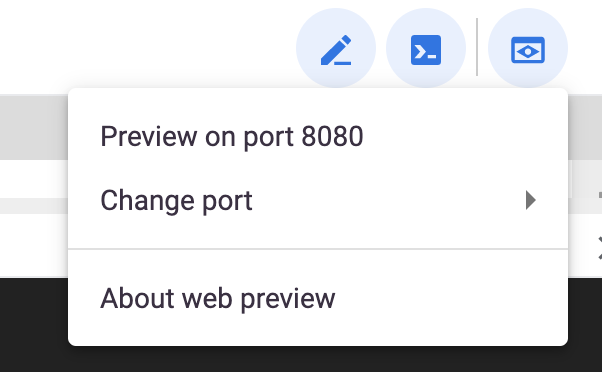

プレビューすると以下のような画面が表示されるはずです

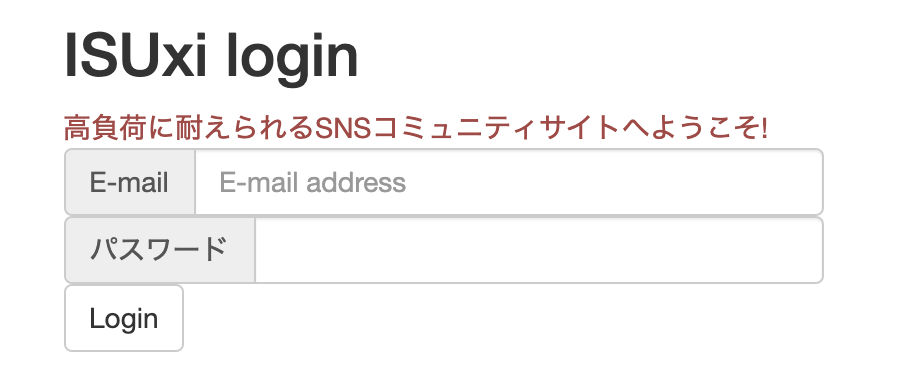

以下のログイン情報を使ってログインしてみましょう

- E-mail: `precious323@isucon.net`
- パスワード: `precious323`

以下のような画面が表示されたら準備完了です

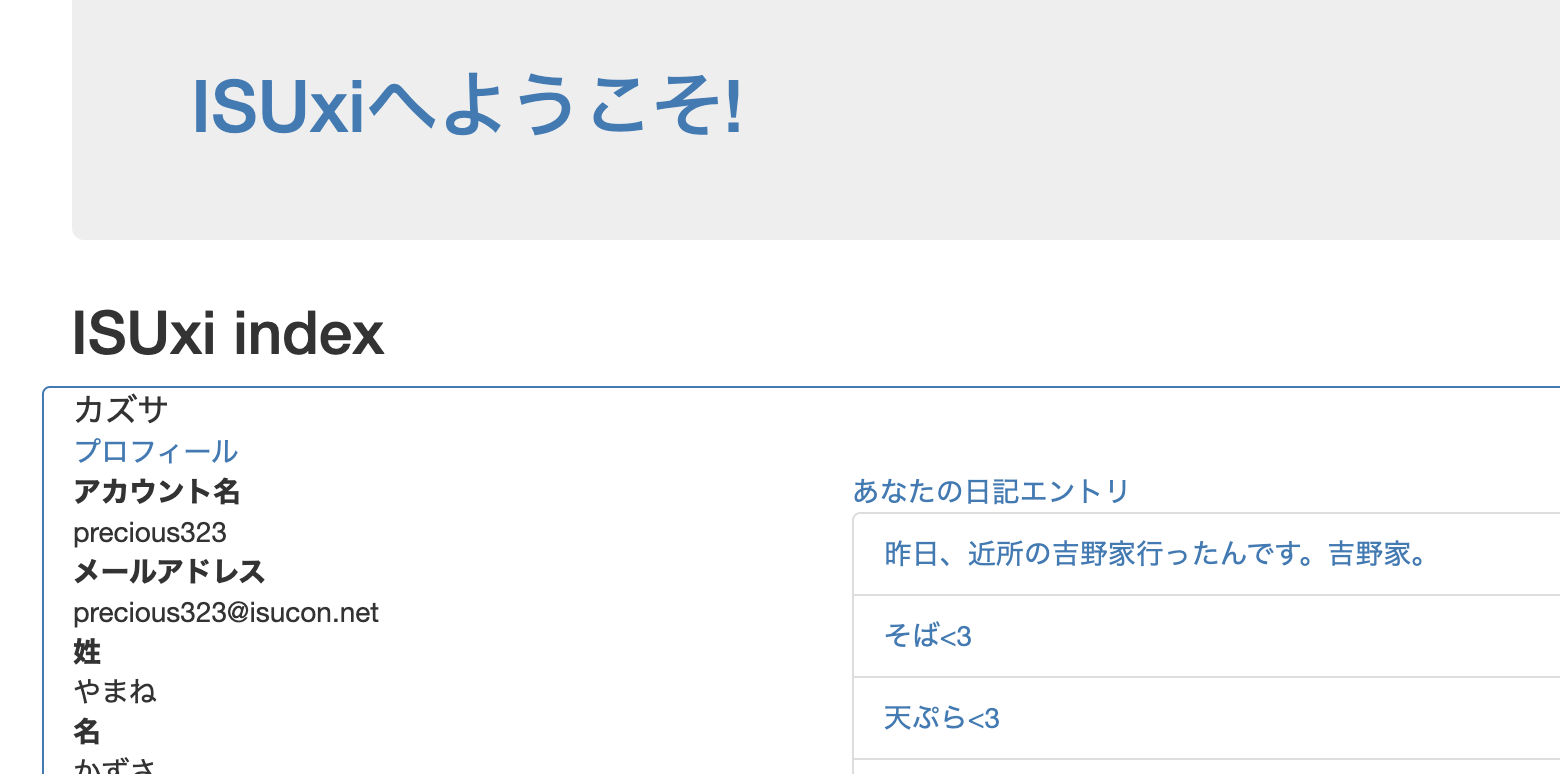

### 5. ベンチマークを実行してみる

アプリケーションの性能を評価するためのベンチマークを用意してあります。演習用インスタンスから以下コマンドを実行するとベンチマークを実行できます

```
$ curl http://10.146.0.4:8888
```

実行には時間がかかるので少々お待ちください。スコアはSlackに通知されます

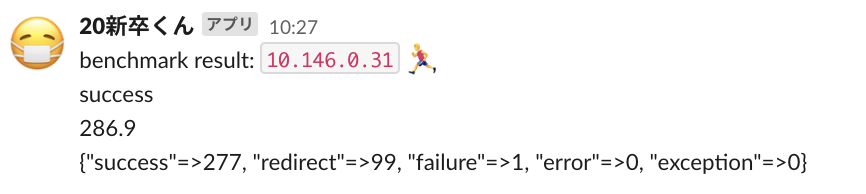

### 遅いクエリを特定してみる

MySQLサーバーに以下のような設定を適用すると実行に時間がかかっているクエリのログを記録してくれます

```
# cat /etc/mysql/conf.d/slow.cnf
[mysqld]
slow_query_log
slow_query_log-file = /tmp/mysql-slow.log
long_query_time = 1
```

上記の設定は実行に1秒以上掛かっているクエリをログに記録します。こちらの設定は既に適用してあるためベンチマーク実行時に時間が掛かっていたクエリが/tmp/mysql-slow.logに記録されているはずです。このログデータを利用して実行に時間が掛かっているクエリを特定してみましょう

以下のコマンドでMySQLのDockerコンテナに入ります

```
$ docker-compose exec mysql bash
```

ここから `#` で始まるコマンドをコンテナの中で実行するコマンドとします

スロークエリを集計するために pt-query-digest をインストールします

```
# apt update && apt install -y wget
# wget https://www.percona.com/downloads/percona-toolkit/3.0.10/binary/debian/xenial/x86_64/percona-toolkit_3.0.10-1.xenial_amd64.deb
# apt update && apt install -y libio-socket-ssl-perl libnet-ssleay-perl libterm-readkey-perl
# dpkg -i percona-toolkit_3.0.10-1.xenial_amd64.deb
```

以下のコマンドが実行できたら準備完了です

```
# pt-query-digest --version
pt-query-digest 3.0.10
```

pt-query-digestでスロークエリを集計してみましょう

```
# pt-query-digest /tmp/mysql-slow.log
```

クエリの実行時間ランキング

```
実行結果1

# Profile
# Rank Query ID           Response time Calls R/Call V/M   Item
# ==== ================== ============= ===== ====== ===== ===============
#    1 0xDE6DD0309F9386F8 27.4776 92.6%    25 1.0991  0.01 SELECT relations
#    2 0x492C7CAB538DE80D  2.2008  7.4%     2 1.1004  0.00 SELECT footprints
```

各クエリの詳細

```
# Query 1: 0.49 QPS, 0.54x concurrency, ID 0xDE6DD0309F9386F8 at byte 1981
# This item is included in the report because it matches --limit.
# Scores: V/M = 0.01
# Time range: 2020-04-14T02:49:48 to 2020-04-14T02:50:39
# Attribute    pct   total     min     max     avg     95%  stddev  median
# ============ === ======= ======= ======= ======= ======= ======= =======
# Count         92      25
# Exec time     92     27s      1s      1s      1s      1s    80ms      1s
# Lock time     45   531us    14us    46us    21us    23us     5us    20us
# Rows sent     99   4.93k     178     220  201.84  212.52   10.73  202.40
# Rows examine  92  11.80M 483.48k 483.53k 483.51k 462.39k       0 462.39k
# Query size    84   2.02k      81      83   82.68   80.10       0   80.10
# String:
# Databases    isucon5q
# Hosts        172.19.0.2
# Users        root
# Query_time distribution
#   1us
#  10us
# 100us
#   1ms
#  10ms
# 100ms
#    1s  ################################################################
#  10s+
# Tables
#    SHOW TABLE STATUS FROM `isucon5q` LIKE 'relations'\G
#    SHOW CREATE TABLE `isucon5q`.`relations`\G
# EXPLAIN /*!50100 PARTITIONS*/
SELECT * FROM relations WHERE one = 3532 OR another = 3532 ORDER BY created_at DESC\G
```

### インデックスの適用

最後に表示されていたクエリをEXPLAIN文で見てみます。コンテナから以下のコマンドを実行してmysqlのコンソールを開いてみましょう

```
# mysql -uroot -pmysql
```

```
Welcome to the MySQL monitor.  Commands end with ; or \g.
Your MySQL connection id is 87
Server version: 8.0.19 MySQL Community Server - GPL

Copyright (c) 2000, 2020, Oracle and/or its affiliates. All rights reserved.

Oracle is a registered trademark of Oracle Corporation and/or its
affiliates. Other names may be trademarks of their respective
owners.

Type 'help;' or '\h' for help. Type '\c' to clear the current input statement.

mysql>
```

以下が対象のクエリでした

```sql
SELECT * FROM relations WHERE one = 3532 OR another = 3532 ORDER BY created_at DESC
```

データベースの切り替え

```sql
mysql> use isucon5q ;
Reading table information for completion of table and column names
You can turn off this feature to get a quicker startup with -A

Database changed
```

EXPLAIN文の実行

```sql
mysql> EXPLAIN SELECT * FROM relations WHERE one = 3532 OR another = 3532 ORDER BY created_at DESC;
+----+-------------+-----------+------------+------+---------------+------+---------+------+--------+----------+-----------------------------+
| id | select_type | table     | partitions | type | possible_keys | key  | key_len | ref  | rows   | filtered | Extra                       |
+----+-------------+-----------+------------+------+---------------+------+---------+------+--------+----------+-----------------------------+
|  1 | SIMPLE      | relations | NULL       | ALL  | friendship    | NULL | NULL    | NULL | 494118 |    10.02 | Using where; Using filesort |
+----+-------------+-----------+------------+------+---------------+------+---------+------+--------+----------+-----------------------------+
1 row in set, 1 warning (0.03 sec)
```

右端の Extra という項目を見てみると `Using filesort` と書いてあります。これは並べ替えを行うときに一時ファイルを生成するため実行に時間が掛かります。

ここでおもむろに relations テーブルの `one` と `another` カラムにインデックスを設定してみます

```sql
mysql> alter table relations add index one_and_another (one, another) ;
Query OK, 0 rows affected (1.44 sec)
Records: 0  Duplicates: 0  Warnings: 0
```

まだ Using filesort が付いております。。。

```sql
mysql> EXPLAIN SELECT * FROM relations WHERE one = 3532 OR another = 3532 ORDER BY created_at DESC;
+----+-------------+-----------+------------+------+----------------------------+------+---------+------+--------+----------+-----------------------------+
| id | select_type | table     | partitions | type | possible_keys              | key  | key_len | ref  | rows   | filtered | Extra                       |
+----+-------------+-----------+------------+------+----------------------------+------+---------+------+--------+----------+-----------------------------+
|  1 | SIMPLE      | relations | NULL       | ALL  | friendship,one_and_another | NULL | NULL    | NULL | 494118 |    10.02 | Using where; Using filesort |
+----+-------------+-----------+------------+------+----------------------------+------+---------+------+--------+----------+-----------------------------+
1 row in set, 1 warning (0.00 sec)
```

このケースでは one と created_at / another と created_at のペアでそれぞれインデックスを作成するとパフォーマンスが上がります

先ほどのインデックスを削除し

```sql
mysql> drop index one_and_another on relations ;
Query OK, 0 rows affected (0.02 sec)
Records: 0  Duplicates: 0  Warnings: 0
```

one + created_at

```sql
mysql> alter table relations add index one_created_at (one, created_at) ;
Query OK, 0 rows affected (1.26 sec)
Records: 0  Duplicates: 0  Warnings: 0
```

another + created_at

```sql
mysql> alter table relations add index another_created_at (another, created_at) ;
Query OK, 0 rows affected (1.48 sec)
Records: 0  Duplicates: 0  Warnings: 0
```

そして EXPLAIN / `\G` を付けると縦向きになります

```sql
mysql> EXPLAIN SELECT * FROM relations WHERE one = 3532 OR another = 3532 ORDER BY created_at DESC \G ;
*************************** 1. row ***************************
           id: 1
  select_type: SIMPLE
        table: relations
   partitions: NULL
         type: index_merge
possible_keys: friendship,one_created_at,another_created_at
          key: friendship,another_created_at
      key_len: 4,4
          ref: NULL
         rows: 208
     filtered: 100.00
        Extra: Using sort_union(friendship,another_created_at); Using where; Using filesort
1 row in set, 1 warning (0.00 sec)
```

Extra に何やら `sort_union` というのが増えました。また、rows に付いて先ほどの explain と見比べてみると50万行程度あったのが200行程度に収まりました